In [24]:
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, cross_validate
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report,make_scorer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import importlib
import scripts.variables as var
import playsound


"""
To beat:

ACCURACY:  0.882525697503671
RECALL:  0.1708008504606662
F1:  0.25078043704474506

"""
def play_done_message():
    playsound.playsound("./data/MamaDoIt.mp3")


importlib.reload(var)


print('DONE')

DONE


[Information about the banking dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing)

In [2]:
#Functions
def creating_X_y(df: pd.DataFrame,features: list[str],target: str='y'):
    """Prepares X and y after dummifying
    fetuares when necessary
    """
    dummies=[col for col in features if col in categorical_columns]
    X=pd.get_dummies(df[features],columns=dummies,dtype=int,drop_first=True)
    y=df[target]
    return X,y

In [3]:
bank=pd.read_csv(var.pathname)
columns_with_nulls=list(bank.isnull().sum()[bank.isnull().sum()>0].index)
print("Columns with nulls: ",columns_with_nulls)

#Default
bank['default'].value_counts(dropna=False)
#Most likely outcome is that this columns does not matter. No information about default.
#it is likely that they have no credit open. Will asign -1
bank['default']=bank['default'].fillna(-1)

#Housing
bank['housing'].value_counts(dropna=False)

#Loan
bank['loan'].value_counts(dropna=False)

##Dropping nulls for housing and loan. Consistent rows. Two birds one shot
bank[(bank.loan.isnull())&(bank.housing.isnull())].shape[0]
bank=bank.dropna(subset=['housing', 'loan'])
bank.isnull().sum().sum()

##CategoricalColumns
dtypes_df=pd.DataFrame(bank.dtypes, columns=['dataType'])
dtypes_df.T

Columns with nulls:  ['default', 'housing', 'loan']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
dataType,int64,object,object,object,float64,float64,float64,object,object,object,int64,int64,int64,object,float64,float64,float64,float64,float64,int64


In [4]:
##Classifying features
categorical_list=list(dtypes_df[dtypes_df.dataType=='object'].index)
pending_columns=[col for col in bank.columns if col not in categorical_list]

boolean_columns=[]
numerical_columns=[]
categorical_columns=[]
for col in bank.columns:
    #print(col.upper())
    if bank[col].nunique() ==2:
        if col not in categorical_list:
            boolean_columns.append(col)
        else:
            pos_value=bank[col].value_counts().index[0]
            bank[f'is_{pos_value}'] = [1 if value==pos_value else 0 for value in bank[col]]
            boolean_columns.append(f'is_{pos_value}')
    elif col in categorical_list or bank[col].nunique()<5:
        categorical_columns.append(col)
        
    else:
        numerical_columns.append(col)
        
boolean_columns.remove('y')
print("CAT COLUMNS: ",categorical_columns,'\n',"NUM COLUMNS: ", numerical_columns,'\n',
     'BOOL COLUMNS: ',boolean_columns)

CAT COLUMNS:  ['job', 'marital', 'education', 'default', 'month', 'day_of_week', 'poutcome'] 
 NUM COLUMNS:  ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] 
 BOOL COLUMNS:  ['housing', 'loan', 'is_cellular']



<a id="top"></a>
<div class="alert alert-block alert-warning">
<b>Categorical Columns:</b> Will proceed to analyze each column one by one
</div>

> Doing crosstabs for all categorical columns to see if I detect some subdivisions that can be used as a thorough predictor.


1. [Jobs.](#jobs) Students and retired are more likely to buy.
2. [Marital.](#marital) Nothing relevant. No deviation seen in the crosstab.
3. [Education.](#education) Illiterate for boolean. It is the only one to highlight in the crosstab
4. [Contact. Binary, no further exploration](#contact) Nothing to highlight.
6. [Month, Day of week.](#dayweek) Month is interesting. If I divided by its count, Dec exceeds the rest and worths to bin. NOthing at all in the weekday front.
7. [poutcome.](#pout) Previous succes is important based on crosstabs.
8. [Default/Housing/Loan.](#default) No subclasses. About default: It only worths pointing out when it comes to default 1 but it only covers 3 cases.
11. [Previous.](#previous) Good predictor. You tend to call people that already bought the product.

<a id="jobs"></a>
1. Jobs

In [5]:
jobs_df=pd.crosstab(bank.y,bank.job,normalize='columns')
jobs_df.style.highlight_max(color='salmon',axis=1)\
        .highlight_min(color='green',axis=1)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
0,0.870231,0.930996,0.914789,0.900097,0.886435,0.747017,0.893555,0.918304,0.690141,0.892511,0.855117,0.886154
1,0.129769,0.069004,0.085211,0.099903,0.113565,0.252983,0.106445,0.081696,0.309859,0.107489,0.144883,0.113846


[Top](#top)

<a id="marital"></a>
2. Marital

In [6]:
marital_df=pd.crosstab(bank.y,bank.marital,normalize='columns')
##Nothing to highlight
marital_df

marital,divorced,married,single,unknown
y,,,,
0,0.895792,0.898439,0.85994,0.848101
1,0.104208,0.101561,0.14006,0.151899


[Top](#top)

<a id="education"></a>
3. Education.

In [7]:
education_df=pd.crosstab(bank.y,bank.education,normalize='columns')
education_df

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
0,0.897265,0.918907,0.921955,0.891339,0.777778,0.88687,0.862417,0.854524
1,0.102735,0.081093,0.078045,0.108661,0.222222,0.11313,0.137583,0.145476


[Top](#top)

<a id="contact"></a>
4. Contact.

In [8]:
contact_df=pd.crosstab(bank.y,bank.contact,normalize='columns')
contact_df

contact,cellular,telephone
y,,
0,0.852988,0.947178
1,0.147012,0.052822


<a id="month"></a>
5. Month/Weekday.

In [9]:
month_df=pd.crosstab(bank.y,bank.month,normalize='columns')
month_df.T[1].sort_index()

month
apr    0.203574
aug    0.105324
dec    0.488636
jul    0.090650
jun    0.106553
mar    0.507491
may    0.064684
nov    0.101615
oct    0.438395
sep    0.445848
Name: 1, dtype: float64

In [12]:
##Months with higher 1 coincide with the months with less calls. Also, I do not believe that it mnight be relevant or using some leakage
bank.month.value_counts().sort_index()

month
apr     2574
aug     6048
dec      176
jul     7027
jun     5143
mar      534
may    13419
nov     4025
oct      698
sep      554
Name: count, dtype: int64

In [13]:
(month_df.T[1].sort_values().sort_index()/bank.month.value_counts().sort_index()).sort_values(ascending=False)

month
dec    0.002776
mar    0.000950
sep    0.000805
oct    0.000628
apr    0.000079
nov    0.000025
jun    0.000021
aug    0.000017
jul    0.000013
may    0.000005
dtype: float64

In [10]:
pd.crosstab(bank.y,bank.day_of_week,normalize='columns')

day_of_week,fri,mon,thu,tue,wed
y,,,,,
0,0.891396,0.900396,0.87918,0.882868,0.882323
1,0.108604,0.099604,0.12082,0.117132,0.117677


[Top](#top)

<a id="pout"></a>
5. Previous Outcome.

In [15]:
poutcome_df=pd.crosstab(bank.y,bank.poutcome,normalize='columns')
poutcome_df

poutcome,failure,nonexistent,success
y,,,
0,0.859454,0.911327,0.350929
1,0.140546,0.088673,0.649071


[Top](#top)

6. Default/housing/Loan.

In [11]:
pd.crosstab(bank.y,bank.default,normalize='columns')

default,-1.0,0.0,1.0
y,,,
0,0.948387,0.871139,1.0
1,0.051613,0.128861,0.0


In [17]:
pd.crosstab(bank.y,bank.housing,normalize='columns')

housing,0.0,1.0
y,,
0,0.891204,0.883806
1,0.108796,0.116194


In [ ]:
pd.crosstab(bank.y,bank.loan,normalize='columns')

[Top](#top)

8. Previous.

In [18]:
pd.crosstab(bank.y,(pd.cut(bank.previous,bins=4,labels=['first', 'second','third', 'fourth'])),normalize='columns')

previous,first,second,third,fourth
y,,,,
0,0.897429,0.508995,0.416667,0.5
1,0.102571,0.491005,0.583333,0.5


In [12]:
bank['previous']=(bank['previous']>0).astype(int)
if 'previous' not in boolean_columns:
    boolean_columns.append('previous')

<a id="top"></a>
<div class="alert alert-block alert-warning">
<b>Numerical Columns:</b> Will proceed to analyze each column one by one
</div>

> Doing crosstabs and/or boxplots to try to understand the relationship of this columns with the target.


1. [Age.](#age) Students and retired are more likely to buy.
2. [Economical indicators (emp.var.rate, cpi...](#marital) Nothing relevant. No deviation seen in the crosstab.
3. [Campaign.](#education) Number of contacts performed during this campaign and for this client.
4. [pdays.](#contact) Number of days that passed by after the client was last contacted from a previous campaign.

1. Age

In [38]:
#lest's create one cat over 50
pd.crosstab(bank.y, pd.cut(bank.age,bins=8),normalize='columns')
#let's create one cat over 50 and rest

age,"(16.919, 27.125]","(27.125, 37.25]","(37.25, 47.375]","(47.375, 57.5]","(57.5, 67.625]","(67.625, 77.75]","(77.75, 87.875]","(87.875, 98.0]"
y,,,,,,,,
0,0.818327,0.891136,0.918917,0.905349,0.795042,0.559172,0.474026,0.529412
1,0.181673,0.108864,0.081083,0.094651,0.204958,0.440828,0.525974,0.470588


In [15]:
bins=[0,20,55,120]
pd.crosstab(bank.y, pd.cut(bank.age,bins=bins,labels=['young','middle age','mature']),normalize='columns')

age,young,middle age,mature
y,,,
0,0.602941,0.897276,0.79331
1,0.397059,0.102724,0.20669


In [16]:
bank['age_groups']=pd.cut(bank.age,bins=bins,labels=['young','middle age','mature'])
if 'age_groups' not in categorical_columns:
    categorical_columns.append('age_groups')

2. Economical Indicators.

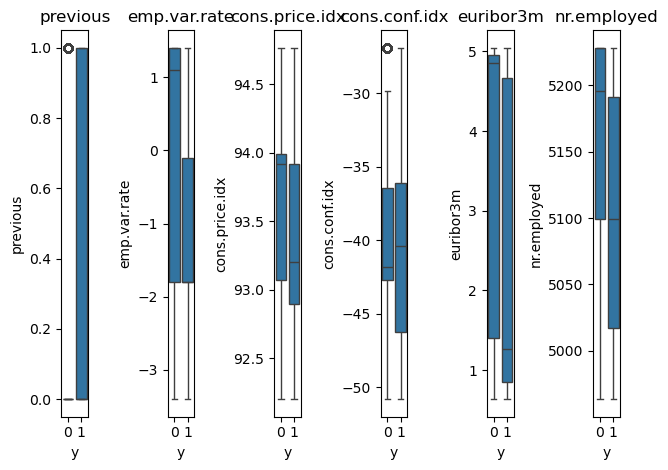

In [17]:
economic_indicators=[col for col in numerical_columns if col not in ['age','campaign','pdays']]
economic_indicators


# Create the figure and two subplots
fig, axes = plt.subplots(ncols=len(economic_indicators))

# Create the boxplot with Seaborn
for column, axis in zip(economic_indicators, axes):
        sns.boxplot(x='y', y=column,data=bank, ax=axis) 
        axis.set_title(column)
        # axis.set(xticklabels=[], xticks=[], ylabel=column)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
#Ones related to employment seem to work better.

3. Campaign.

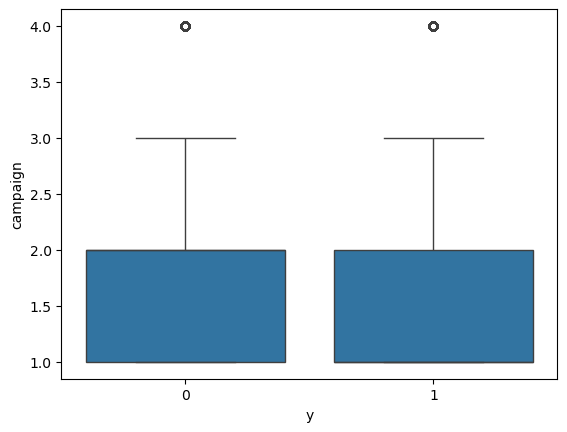

In [18]:
bank.campaign.describe()
#sns.boxplot(x='y',y='campaign',data=bank)
cutoff=bank.campaign.describe(percentiles=[.25, .5, .75,.9,.95]).loc['90%']
bank[bank.campaign<cutoff]
sns.boxplot(x='y',y='campaign',data=bank[bank.campaign<cutoff]);
#No relevance

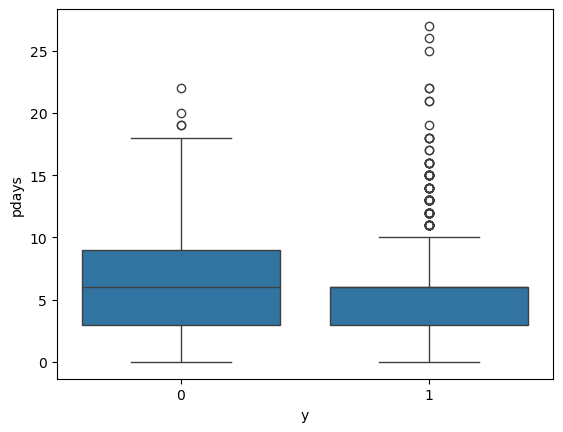

In [19]:
bank[bank.pdays<bank.pdays.describe().loc['25%']]
sns.boxplot(x='y',y='pdays', data=bank[bank.pdays<bank.pdays.describe().loc['25%']]);
#No much relevance plus I feel this info is contained in other features.

In [20]:

print("CAT COLUMNS: ",categorical_columns,'\n',"NUM COLUMNS: ", numerical_columns,'\n',
     'BOOL COLUMNS: ',boolean_columns)

CAT COLUMNS:  ['job', 'marital', 'education', 'default', 'month', 'day_of_week', 'poutcome', 'age_groups'] 
 NUM COLUMNS:  ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] 
 BOOL COLUMNS:  ['housing', 'loan', 'is_cellular', 'previous']


In [21]:
features_selected=categorical_columns + boolean_columns
X,y= creating_X_y(bank,features_selected)


# Initialize SelectKBest with chi2 and k=2
selector = SelectKBest(chi2, k=2).fit(X, y)

# Get the feature scores and names
scores = selector.scores_
feature_names = X.columns


# Create a DataFrame to display the ranking
feature_ranking = pd.DataFrame({'Feature': feature_names, 'Score': scores})
feature_ranking = feature_ranking.sort_values(by='Score', ascending=False)

print(feature_ranking[:10])
top_categorical=list(feature_ranking['Feature'].values)
top_10_cat=list(feature_ranking[:10]['Feature'].values)


              Feature        Score
41   poutcome_success  3866.562386
3            previous  1274.421269
31          month_mar   831.589312
34          month_oct   739.744050
35          month_sep   614.316129
11        job_student   330.795869
8         job_retired   329.346564
32          month_may   310.079746
43  age_groups_mature   308.419755
2         is_cellular   299.863629


In [22]:
X,y= creating_X_y(bank,numerical_columns)

scores = selector.scores_
feature_names = X.columns
# Select the top k features based on the chi-squared score
selector = SelectKBest(score_func=f_classif, k='all').fit(X, y)
scores = selector.scores_
feature_names = X.columns

feature_ranking = pd.DataFrame({'Feature': feature_names, 'Score': scores})
feature_ranking = feature_ranking.sort_values(by='Score', ascending=False)
print(feature_ranking)
top_numerical=list(feature_ranking['Feature'].values)
#top_numerical

          Feature        Score
8     nr.employed  5720.491104
2           pdays  4701.549358
7       euribor3m  4161.120665
4    emp.var.rate  3900.371626
3        previous  1532.007977
5  cons.price.idx   754.134596
1        campaign   174.486285
6   cons.conf.idx   123.419827
0             age    36.984408


<a id="top"></a>
<div class="alert alert-block alert-warning">
<b>Modeling:</b> Will proceed to try different models. I will use Logistic Regression, random Forest and another one.
</div>

> Will use cross val and resampling. The score that I will use as a baseline is that of 0.89 accuracy and 0.17 recall
> that we had from a former exercise.

1. **Using all features, SMOTE, Logistic Regression and Standard Scaler.**

In [26]:
all_features=numerical_columns + categorical_columns + boolean_columns
X,y =creating_X_y(bank, all_features)

X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y, random_state=1992)
model=LogisticRegression(max_iter=500)
upsampling=SMOTE()
scaler=StandardScaler()
pipeline=Pipeline([('Scaler',scaler),('SMOTE', upsampling),('Logistic Regression', model)])
cv=StratifiedKFold(shuffle=True,random_state=1992)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}
scores=cross_validate(pipeline,X_train,y_train, scoring=scoring, cv=cv)
print(f'My scores in train validation are {scores["test_recall"].mean().round(3)} recall,{scores["test_f1"].mean().round(3)} as per f1 and an accuracy of {scores["test_accuracy"].mean().round(3)}')
pipeline.fit(X_train,y_train)
preds=pipeline.predict(X_test)
print(f'As per the test: {round(recall_score(y_test,preds),3)}, the f1 is {round(f1_score(y_test,preds),3)}\
 and its accuracy amounts to {round(accuracy_score(y_test,preds),3)}')
data_to_save=(pipeline, X_test,y_test,X_train,y_train,cv)
with open ('model_pickled.pkl','wb') as MODEL:
    pickle.dump(data_to_save,MODEL)
    

My scores in train validation are 0.637 recall,0.438 as per f1 and an accuracy of 0.816
As per the test: 0.637, the f1 is 0.438 and its accuracy amounts to 0.816


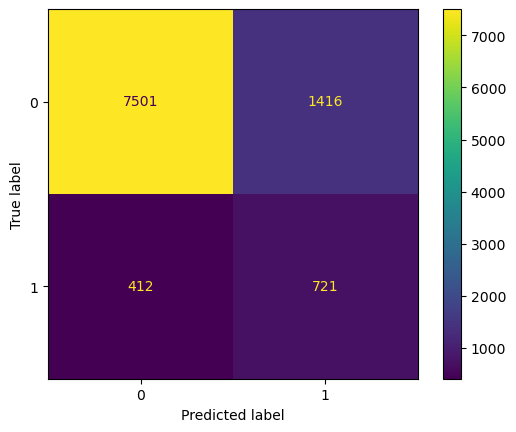

In [232]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [244]:
#let's evaluate the Falses Positives and Negatives
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel() 
total=tn+fp+fn+tp
print('Predicted maj: ', tn+fn, round((tn+fn)*100/total,2),'\n', 'Predicted min: ', tp+fp,round((tp+fp)*100/total,2))

print(classification_report(y_test, preds))

Predicted maj:  7913 78.74 
 Predicted min:  2137 21.26
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      8917
           1       0.34      0.64      0.44      1133

    accuracy                           0.82     10050
   macro avg       0.64      0.74      0.67     10050
weighted avg       0.88      0.82      0.84     10050



> Big improvement in recall (46 points) while losing only 7 points of accuracy compared to our baseline. Also, suroprisingly, it did not show "evident" signs of overfitting despite using all the features. It will be interested to make an analysis on how things change if I put a cost in fp and fn (ref another notebook). Still 75% of the predictions were for the Majority Class


2. **Using only selected features with SMOTE and Logistic Regression and Standard Scaler.**

In [254]:
all_features=numerical_columns + categorical_columns + boolean_columns
X,y =creating_X_y(bank, all_features)
selected_features= top_numerical[:3] + top_categorical[:3]
X=X[selected_features]
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y, random_state=1992)
model=LogisticRegression(max_iter=500)
upsampling=SMOTE()
scaler=StandardScaler()
pipeline=Pipeline([('Scaler',scaler),('SMOTE', upsampling),('Logistic Regression', model)])
cv=StratifiedKFold()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}
scores=cross_validate(pipeline,X_train,y_train, scoring=scoring, cv=cv)
print(f'My scores in train validation are {scores["test_recall"].mean().round(3)} recall,{scores["test_f1"].mean().round(3)} as per f1 and an accuracy of {scores["test_accuracy"].mean().round(3)}')
pipeline.fit(X_train,y_train)
preds_lr=pipeline.predict(X_test)
print(f'As per the test: {round(recall_score(y_test,preds_lr),3)} recall, the f1 is {round(f1_score(y_test,preds_lr),3)}\
 and its accuracy amounts to {round(accuracy_score(y_test,preds_lr),3)}')

My scores in train validation are 0.675 recall,0.397 as per f1 and an accuracy of 0.768
As per the test: 0.702 recall, the f1 is 0.355 and its accuracy amounts to 0.713


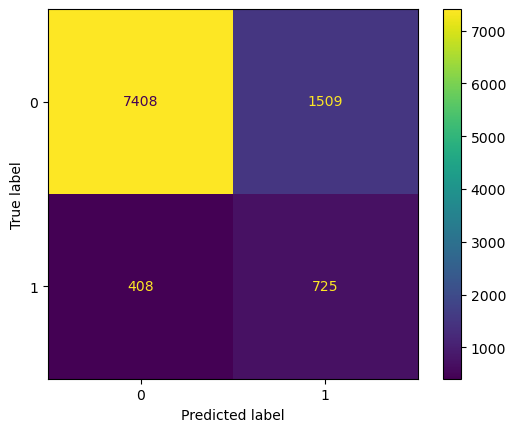

In [252]:
#confusion matrix
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [253]:
#let's evaluate the Falses Positives and Negatives
tn, fp, fn, tp = confusion_matrix(y_test,preds_lr).ravel() 
total=tn+fp+fn+tp
print('Predicted maj: ', tn+fn, round((tn+fn)*100/total,2),'\n', 'Predicted min: ', tp+fp,round((tp+fp)*100/total,2))

print(classification_report(y_test, preds_lr))

Predicted maj:  7816 77.77 
 Predicted min:  2234 22.23
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      8917
           1       0.32      0.64      0.43      1133

    accuracy                           0.81     10050
   macro avg       0.64      0.74      0.66     10050
weighted avg       0.88      0.81      0.83     10050



> Lost a little bit of recall while gaining some accuracy. Does not worth limiting features. I tried different number of features with similar results. As I reduce the number of features my recall increases up to 72 points while accuracy pays for it going down to 72. It is all well explained looking at f1 score: down to 35 from 44 in the worst case. Something similar happened when I use a downsampler (TomekLinks) instead of SMOTE. 

3. **Moving to random Forest**

In [258]:
all_features=numerical_columns + categorical_columns + boolean_columns
X,y =creating_X_y(bank, all_features)
# selected_features= top_4_numerical + top_10_cat
# X=X[selected_features]
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y, random_state=1992)
model=RandomForestClassifier()
upsampling=SMOTE()
scaler=StandardScaler()
pipeline=Pipeline([('Scaler',scaler),('SMOTE', upsampling),('random Forest', model)])
cv=StratifiedKFold()
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score)
}
scores=cross_validate(pipeline,X_train,y_train, scoring=scoring, cv=cv)
print(f'My scores in train validation are {scores["test_recall"].mean().round(3)} recall,{scores["test_f1"].mean().round(3)} as per f1 and an accuracy of {scores["test_accuracy"].mean().round(3)}')
pipeline.fit(X_train,y_train)
preds_rf=pipeline.predict(X_test)
print(f'As per the test: {round(recall_score(y_test,preds_rf),3)} recall, the f1 is {round(f1_score(y_test,preds_rf),3)}\
 and its accuracy amounts to {round(accuracy_score(y_test,preds_rf),3)}')

My scores in train validation are 0.361 recall,0.422 as per f1 and an accuracy of 0.889
As per the test: 0.37 recall, the f1 is 0.425 and its accuracy amounts to 0.887


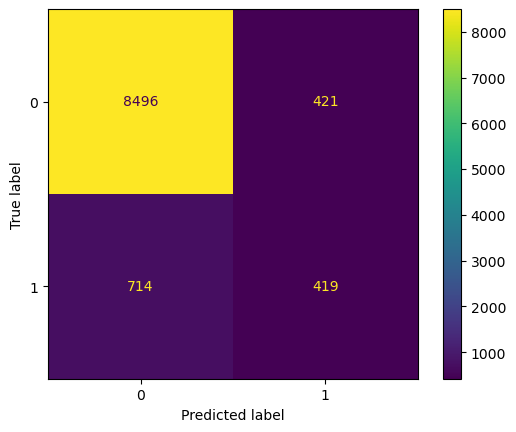

In [259]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [260]:
#let's evaluate the Falses Positives and Negatives
tn, fp, fn, tp = confusion_matrix(y_test,preds_rf).ravel() 
total=tn+fp+fn+tp
print('Predicted maj: ', tn+fn, round((tn+fn)*100/total,2),'\n', 'Predicted min: ', tp+fp,round((tp+fp)*100/total,2))

print(classification_report(y_test, preds_rf))

Predicted maj:  9210 91.64 
 Predicted min:  840 8.36
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      8917
           1       0.50      0.37      0.42      1133

    accuracy                           0.89     10050
   macro avg       0.71      0.66      0.68     10050
weighted avg       0.87      0.89      0.88     10050



> Interstingly, Random Forest that usually works wonders for me gives a very disappointing results. Using all features, it brings down recall to 0.37 (almost have of Logistic Regression) while recovering old levels of total accuracy. I will make aa analysis adding some cost in the fp and fn to see if it si a better fit. Random Forest brings up the percentage of majority class predicted to 89%. It is still way better compared to our initial baseline.

# Summary:
1. Using all features seems to me did not generate overfitting.
2. Logistic regression and SMOTE are more effective detecting the minority class in exchange of losing some accuracy.
3. Must analyze the distribution of FP and FN in the next notebook. I will save the model withh al features and Logistic regression plus SMOTE to work on my Cost Analysis in binary classification. 